# Optimisation de portefeuille à partir d'analyse de sentiment des news 

## Chargement des librairies

In [1]:
!pip install wordcloud
!pip install nltk
!pip install yfinance
!pip install plotly
!pip install pandas_datareader
!pip install tabulate

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


# Partie wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import urllib


# Partie NLP
import nltk

nltk.download('punkt')
words = nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from tabulate import tabulate

# Partie DataViz
import math
import seaborn as sns
import yfinance as yf
import datetime 

import plotly.graph_objects as go
import plotly.express as px


# Partie modelisation/optmisation

from numpy import matrix, array, zeros, empty, sqrt, ones, dot, append, mean, cov, transpose, linspace

from numpy.linalg import inv, pinv

import pandas_datareader as pdr
from datetime import datetime
from pylab import *


import scipy.optimize
import random

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coren\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\coren\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\coren\AppData\Roaming\nltk_data...


## Webscrapping des titres de news

L'objectif de cette partie est de récupérer tout les titres des news associés aux différentes entreprises capitalisées dans le S&P500 qui correspond au premier indice boursier mondial et représente plus de 70 % de la capitalisation boursière de New York. Il est composé des 500 plus grandes entreprises.
Pour cela on effectue du webscrapping sur le site Investing.com plateforme financière et site web d'information qui répertorie les dernières news associées à chaque entreprises. L’objectif est d’obtenir un dictionnaire contenant les entreprises ainsi que les titres des 30 dernières news associées.
 
- Dans un premier temps, on récupère le nom de toutes les entreprises inclue dans le S&P500.
- Dans un second temps, on récupère les 30 dernières news associés à chaque compagnies.
- Enfin, on réunit le tout dans un dictionnaire.

In [3]:
def get_company():

    """
    Cette fonction récupère une liste contenant le noms des différentes entreprises du S&P500 sur Investing.com 
    
    Sortie = liste des entreprises
    """
    
    url = 'https://fr.investing.com/indices/investing.com-us-500-components'
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}) #on utilise "User agent" pour faire croire au site que c'est un veritable utilisateur qui souhaite se connecter et non pas un bot
    soup = BeautifulSoup(r.content, 'html.parser')
    tbody = soup.findAll("td",{"class":"bold left noWrap elp plusIconTd"})
    l = []
    for p in tbody:
        l.append(p.find("a")['href'].split('/')[2])
    return l

In [4]:
liste_entreprise = get_company()
#liste_entreprise

In [5]:
def get_news(company,nb_page=1):
    """
    Cette fonction permet de récupérer les titres des news associés à une compagnie sur une page donnée
    
    Entrée : 
    company = le nom de l'entreprise dont on souhaite obtenir les news (format = chaine de caractère). Elle doit correspondre à une page d'investing.com
    nb_page = numero de la page sur lesquels on souhaite retourner les news (1 page = 10 titres) (format = int), initialisé à 1
    
    Sortie:
    liste = liste de titre de news
    """

    url = 'https://www.investing.com/equities/'+company+'-news/'+str(nb_page)
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    article_body = soup.findAll("a",{"class":"title"})
    l=[]
    for p in article_body:
        l.append(p.get("title"))
    return l[6:] #les 6 premiers titre correspondent à des pubs (sur toute les pages...)

In [6]:
print(get_news("tesla-motors",3))

['Explainer-How Tesla weathered global supply chain issues that knocked rivals', 'Wall Street Opens at Fresh Highs on Omicron Hopes; Dow up 225 Pts', 'Apple, Ford Rise Premarket; Foot Locker, Warner Music Fall', 'Dow Futures Rise 125 Pts; Optimism Rises Despite Record Covid Cases', 'European Stocks Higher; German Retail Sales Help Optimism', 'European Stock Futures Higher; New Year Optimism Continues', 'Apple becomes first company to hit $3 trillion market value, then slips', 'Wall Street downplays worries in wishful start to 2022', "Tesla's bumper delivery numbers charge up shares", 'S&P 500, Dow hit record highs on 1st trading day of 2022', 'Alvexo - Non-Farm Payroll Report (NFP): Live Trading Event', 'Alvexo - Getting Started with Technical Analysis', 'Alvexo - Simple and Useful Fibonacci Retracement Technical Indicator', 'Alvexo - Bollinger Band Trading']


In [7]:
def get_tilte_dictionary(company_list, number_page=1):
    """
    Cette fonction permet de créer un dictionnaire en associant chaque companie avec ses titres de news
    
    Entrée : 
    company_list = liste des noms d'entreprises dont on souhaite obtenir les news
    nb_page = nombre de pages sur lesquels on souhaite itérer
    
    Sortie:
    dictionnaire : clé = companie
                   valeur = texte contenant tout les titres
    """

    dicto = {}
    for company in company_list :
        l = []
        for page in range(1,number_page+1):
            l = l + get_news(company, page)
        dicto[str(company)] = ' '.join(l).lower()
        print(company) #cela sertt à voir si la fonction marche bien suite à certains problèmes
    
    return dicto


## Word cloud
Pour donner un exemple on effectue un wordcloud avec l’entreprise Boeing

In [8]:
data = get_tilte_dictionary(liste_entreprise[:100],1) #Atention compilation longue environ 7-8min

3m-co
abbott-laboratories
abbvie-inc
accenture-ltd
activision-inc
acuity-brands-inc
adobe-sys-inc
auto-data-process
advance-auto-parts
affiliated-managers-group-inc
aflac-inc
agilent-tech
american-intl-group
air-prods---chem
akamai-technologies-inc
alaska-air
albemarle
alexandria-real-estate-equities
align-technology
allegion-public
alliance-data-systems
alliant-energy
allstate-corporation
google-inc
google-inc-c
altria-group
amazon-com-inc
adv-micro-device
ameren-corp
american-airlines-group
american-electric
american-express
amer-tower-corp
american-water-works-inc
ameriprise-fincl
amerisourcebergn
ametek-inc
amgen-inc
amphenol-corp
analog-devices
ansys
wellpoint-inc
a.o-smith-corp
aon-corp
apache-corp
apt-inv-manage
apple-computer-inc
applied-matls-inc
delphi-automotive
archer-daniels-mid
arconic-inc
arthur-j.-gallagher---co
assurant
at-t
autodesk-inc
autozone-inc
avalonbay-comm
avery-dennison
baker-hughes
ball-corp
bank-of-america
bk-of-ny
limited-brands
baxter-intl
becton-dickinsn

In [9]:
print(data['boeing-co'])

atlas air invests in four new boeing 777 freighters : atlas air has ordered 4 new boeing 777 freighters boeing bags order of up to 100 737 max jets from allegiant allegiant air buys 50 new boeing 737 max jets in strategy shift allegiant air to buy 50 boeing 737 max jets allegiant air confirms purchase of 50 new boeing 737 max jets boeing stock gains after allegiant orders 50 737 max jets, with options for another 50 jets allegiant air buys 50 new boeing 737 max jets in strategy shift exclusive-u.s. carrier allegiant air to buy 50 boeing 737 max jets -sources allegiant air nears deal for 50 boeing 737 max jets - reuters alvexo - non-farm payroll report (nfp): live trading event alvexo - getting started with technical analysis alvexo - simple and useful fibonacci retracement technical indicator alvexo - bollinger band trading


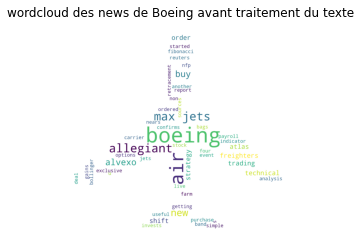

In [10]:
mask = np.array(Image.open(requests.get('https://www.freeiconspng.com/uploads/airplane-icon-image-gallery-1.png', stream=True).raw))

wordcloud = WordCloud(background_color = 'white', max_words = 50, mask  = mask).generate(data['boeing-co'])
plt.imshow(wordcloud)
plt.axis("off")
plt.title('wordcloud des news de Boeing avant traitement du texte')
plt.show();

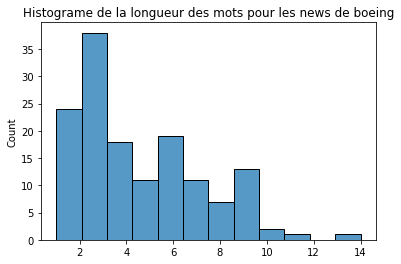

In [11]:
sns.histplot([len(i) for i in data['boeing-co'].split()  ])
plt.title('Histograme de la longueur des mots pour les news de boeing')
plt.show()

## NLP Analyse de sentiment
L’idée de cette partie consiste à analyser les sentiments donnés par les 30 titres des dernières news et de récupérer les 20 entreprises dont les sentiments sont les plus positifs afin de réaliser un portefeuille à partir de ces 20 capitalisations.
 
- Dans un premier temps, on nettoie les données avec la tokenisation qui découpe le texte en morceaux, on retire les signes de ponctuation, puis on retire les stopwords (mot communs inutiles) puis on effectue la racinisation (stemming) qui extrait la racine des mots.
- Dans un second temps, on applique au texte nettoyé un algorithme d’analyse de sentiment pré-entrainé qui renvoient des scores de mots positifs/neutres/négatifs. On retourne alors un score associé à chaque entreprise en donnant un poids arbitraire sur les score positif/neutre/négatif.
- Enfin, on récupère les résultats dans un dataframe et on garde que les 20 entreprises avec les avis les plus positifs.
 

In [12]:
def clean_text(text):
    """
    Cette fonction permet de nettoyer les textes pour pouvoir les traiter et les analyser
    
    Entrée : 
    texte = texte brut contenant les titres des news associés à une compagnie
    
    Sortie:
    texte = texte nettoyé 
    """
    
    words = nltk.word_tokenize(text)
    
    words = [word for word in words if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    keep_words = ['up', 'down', 'under','no'] 
    stop_words = [word for word in stop_words if word not in keep_words]
    words = [ word for word in words if not word in stop_words]
    
    stemmer = SnowballStemmer(language = 'english')
    stemmed = [stemmer.stem(word) for word in words]
    
    return(' '.join(stemmed))

In [13]:
def return_sentiment(company_data):
    """
    Cette fonction permet de retourner l'analyse de sentiment à une compagnie donnée.
    
    Entrée : 
    company_data = texte de titre de news associé à une companie
    
    Sortie:
    texte = score d'analyse de sentiment avec des poids de 10 aux mots à connotation positive, 1 aux mots neutres et -15 pour les mots à connotation négatives. Ces poids ont étés choisi arbitrairement donc discutable.
    """
    
    text = clean_text(company_data)
    sid = SentimentIntensityAnalyzer()
    l = sid.polarity_scores(clean_text(company_data))
    return(l['pos']*10 + l['neu'] - l['neg']*15) 

In [14]:
def build_data_sentiment(company_list, page=1):
    """
    Cette fonction permet de compiler toutes les fonctions précedemment définis. A partir d'une liste de compagnie, cette fonction retourne un dataframe avec deux colonnes les companies associés à leur score d'analyse de sentiment
    
    Entrée : 
    company_list = liste des noms d'entreprises dont on souhaite obtenir les news
    nb_page = nombre de pages sur lesquels on souhaite itérer
    
    Sortie:
    df = dataframe avec une colonne des compagnie et une colonne de score d'analyse de sentiment
    """
    data = get_tilte_dictionary(company_list, page)
    df = pd.DataFrame(columns = ['company','score'])
    for company in company_list : 
        df = df.append({'company': str(company), 'score':return_sentiment(data[company])},ignore_index=True)
    return df

In [15]:
df = build_data_sentiment(liste_entreprise,3) #Attention le compilage de cette fonction est très long 30min-1h!

3m-co
abbott-laboratories
abbvie-inc
accenture-ltd
activision-inc
acuity-brands-inc
adobe-sys-inc
auto-data-process
advance-auto-parts
affiliated-managers-group-inc
aflac-inc
agilent-tech
american-intl-group
air-prods---chem
akamai-technologies-inc
alaska-air
albemarle
alexandria-real-estate-equities
align-technology
allegion-public
alliance-data-systems
alliant-energy
allstate-corporation
google-inc
google-inc-c
altria-group
amazon-com-inc
adv-micro-device
ameren-corp
american-airlines-group
american-electric
american-express
amer-tower-corp
american-water-works-inc
ameriprise-fincl
amerisourcebergn
ametek-inc
amgen-inc
amphenol-corp
analog-devices
ansys
wellpoint-inc
a.o-smith-corp
aon-corp
apache-corp
apt-inv-manage
apple-computer-inc
applied-matls-inc
delphi-automotive
archer-daniels-mid
arconic-inc
arthur-j.-gallagher---co
assurant
at-t
autodesk-inc
autozone-inc
avalonbay-comm
avery-dennison
baker-hughes
ball-corp
bank-of-america
bk-of-ny
limited-brands
baxter-intl
becton-dickinsn

In [16]:
df = df.set_index('company')
ordered_df = df['score'].sort_values(ascending = False)

In [17]:
kept_company = ordered_df[:20]
print(kept_company)

company
signet-jewelers-limited     3.094
pepsico                     2.061
kinder-morgan               2.036
target                      1.998
metlife-inc                 1.961
polo-ralph-laur             1.914
amazon-com-inc              1.889
discover-financl            1.849
mastercard-cl-a             1.827
zoetis-inc                  1.798
northern-trust              1.787
waste-managemnt             1.786
motorola-inc                1.774
kroger-co                   1.766
humana-inc                  1.751
hershey-co                  1.747
essex-property-trust-inc    1.747
qorvo-inc                   1.742
adv-micro-device            1.725
kohls-corp                  1.721
Name: score, dtype: float64


## Data vizualiation avec Yahoo Finance
L’objectif de cette partie est d’explorer les données financières du portefeuille constitué suite à l’analyse de sentiment au moyen de data visualisation et Yahoo Finance.
 
- Dans un premier temps, on récupère les tickers de chaque entreprises gardés dans notre portefeuille puis à partir des tickers on retrouve les noms réels des entreprises.
- On charge ensuite les données et on récupère que les prix de clôture et on affiche alors les cours boursiers de notre portefeuille ainsi qu'un lissage de type moving average.
- Enfin nous affichons la matrice de correlation de nos rendements.

In [18]:
def get_tickers(company):
    
    """
    Cette fonction retourne le ticker d'une entreprise à partir de son nom sur investing
    
    Entrée:
    company : string contenant le nom de l'entreprise sur investing
    
    Sortie:
    ticker :  string contenant le ticker correspondant
    """
    
    url = 'https://www.investing.com/equities/'+company
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    article_body = soup.findAll("h1",{"class":"text-2xl font-semibold instrument-header_title__GTWDv mobile:mb-2"})
    #print(article_body)
    ticker = str(re.search(r'\((.*?)\)',str(article_body)).group(0) )
    ticker = re.search(r'[a-zA-Z]+',ticker ).group(0) 
    return ticker

In [19]:
def get_ticker_list(kept_company):
    
    """
    Cette fonction retourne la liste des tickers d'une entreprise à partir de son nom sur investing
    
    Entrée:
    kept_company: liste des compagnies gardées suite à l'analyse de sentiment contenant les noms des entreprises sur investing
    
    Sortie:
    liste :  liste contenant les tickers correspondant
    """
    
    l=[]
    for i in range(len(kept_company)):
        l.append(get_tickers(kept_company.index[i]))
    return l

In [20]:
#get_ticker_list(kept_company)

In [21]:
tickers = get_ticker_list(kept_company)

In [22]:
def retrieve_ticker_name(tickers):
    
    """
    Cette fonction permet de retrouver les noms réels des compagnies à partir de la liste des tickers
    
    Entrée:
    tickers : liste des tickers des entreprises
    
    Sortie:
    liste :  liste contenant les noms réels des entreprises
    """
    
    l = []
    for i in tickers:
        stock = yf.Ticker(i)
        if stock.info['longName'] == None:
            l.append(i)
        else:
            l.append(stock.info['longName'])
    return(l)

ticker_name = retrieve_ticker_name(tickers)

In [23]:
def load_data(tickers, start = datetime.datetime(2012,5,31), end = datetime.datetime.now() ):
    
    """
    Cette fonction permet de charger les données financières associées aux tickers.
    
    Entrée:
    tickers : liste des tickers des entreprises
    start : date de début de la plage de temps choisie, initialisé au 31/05/2012
    end : date de fin de la plage de temps choisie, initialisé à la date d'aujourd'hui
    
    Sortie:
    df :  dataframe contenant les données financières associés aux différents tickers
    """
    
    df = yf.download(tickers, start, end, group_by="ticker") 
    #print(df)
    return(df)
    
data = load_data(tickers)

[*********************100%***********************]  20 of 20 completed


In [24]:
def keep_close(tickers, data):
    
    """
    Cette fonction permet de garder seulement les données financières de clôture des marchés (ajustées) associées aux tickers.
    
    Entrée:
    tickers : liste des tickers des entreprises
    data : dataframe contenant les données financières associés aux différents tickers
    
    Sortie:
    df :  dataframe contenant les données de clôture ajustées associés aux différents tickers
    """
    
    df = pd.DataFrame()
    for i in tickers:
        Close = data[i]["Adj Close"]
        df[i] = Close
    return df

data_close = keep_close(tickers, data)

In [28]:
def plot_finance(ticker, data):
    df = data[ticker]

    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)])

    fig.update_layout(
        title=ticker_name[0]+' full stock price',
        yaxis_title="Price in $ USD")

    fig.show()
    
plot_finance(tickers[0], data)

In [29]:
def tendance(prix, window = 5):
    """
    Cette fonction renvoie le moving average du prix de cloture
    
    Entrée :
    prix : prix de cloture
    window = fenêtre de calcul
    
    Sortie:
    df : dataframe dont les colonnes sont: prix et moving average
    """
    
    l = list(prix[:window])
    for i in range(window, len(prix) ):
        l.append(mean(list(prix[i-5:i])))
    df = pd.Series(l, index = prix.index)
    
    return df

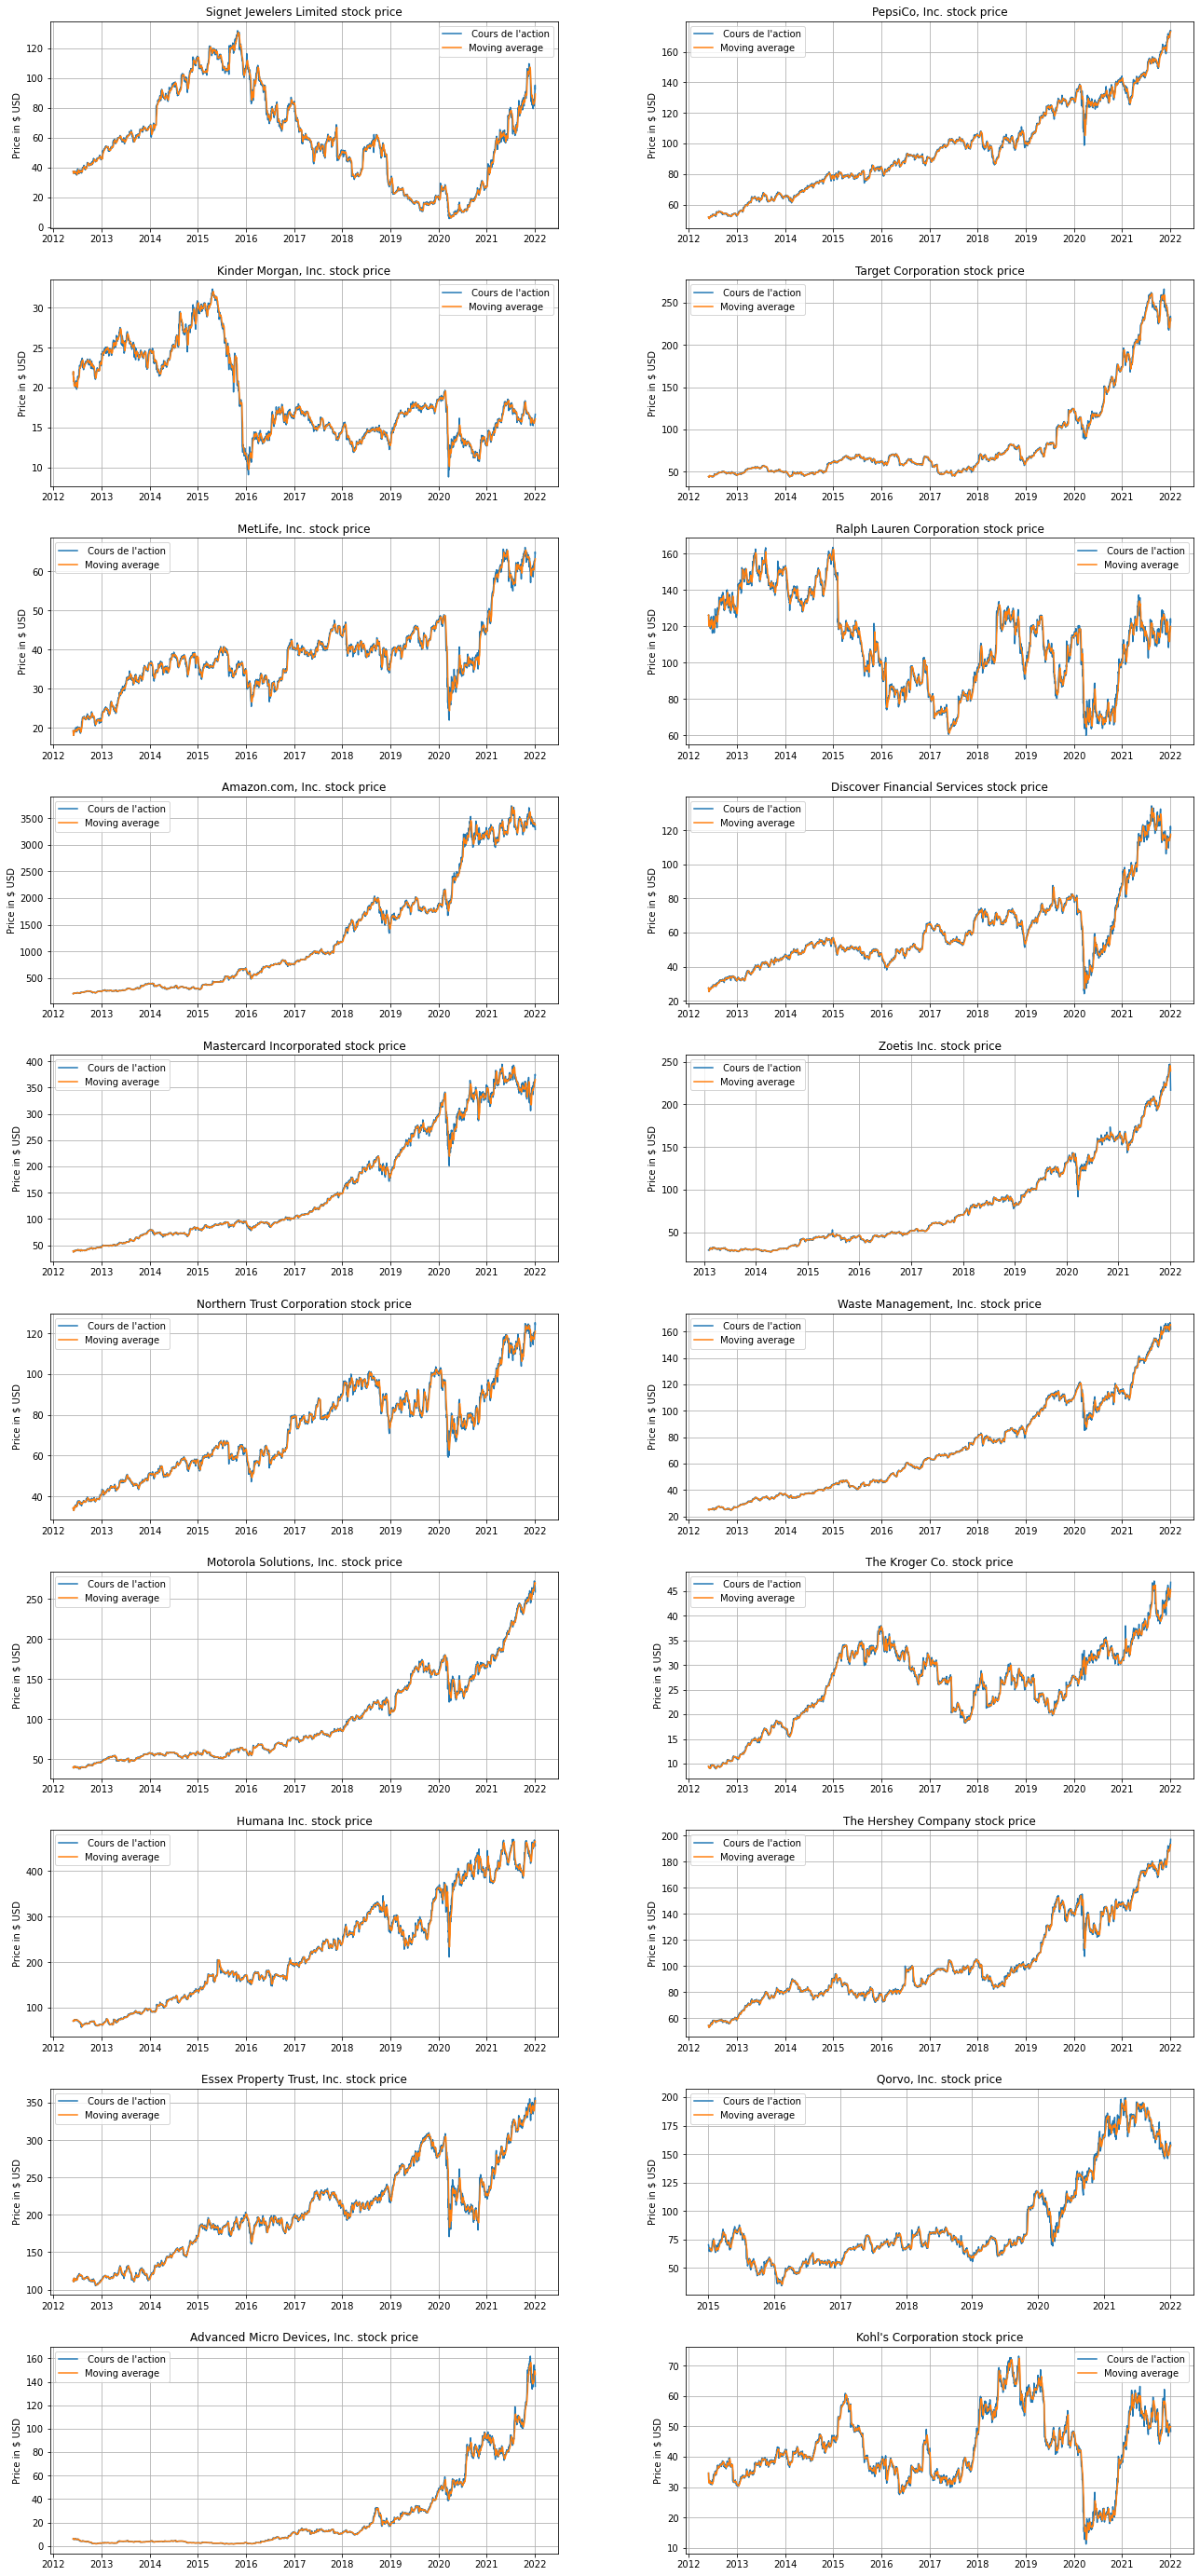

In [31]:
fig = plt.figure(figsize=(22, 50))
rows = 10
columns =2
grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)
for i in range(rows*columns):
    exec (f"plt.subplot(grid{[i]})")
    plt.plot(data_close[tickers[i]], label=" Cours de l'action")
    df = tendance(data_close[tickers[i]], 10)
    plt.plot(df, label='Moving average')
    plt.legend()
    plt.grid()
    plt.title(ticker_name[i] +" stock price")
    plt.ylabel("Price in $ USD")

In [32]:
data_log_close = data_close.apply(np.log, axis=1)
data_return = data_log_close - data_log_close.shift(1)
data_return = data_return.iloc[1: , :]
corr = data_return.corr()
corr.style.background_gradient(cmap='coolwarm')

## Modélisation/Optimisation du portefeuille

L'idée de cette deuxième partie est de modéliser la construction d'un portefeuille à partir des prix de clôtures et des capitalisations boursières des entreprises considérées.

- Dans un premier temps, l'objectif est de construire les différentes métriques requises pour appliquer un modèle classique de construction de portefeuille, le CAPM : L'objectif ici est de calculer les rendements de chaque actifs considérés ainsi que leur volatilité mesurée par l'écart-type. Il est également nécéssaire de calculer les covariances entre les différents actifs.

- Dans un second temps, on arrive à calculer les poids de chaque entreprise dans le S&P500 grâce à une division du MarketCap de chaque entreprise sur le MarketCap total de chaque entreprise.

- Enfin, on applique le CAPM et la théorie moderne du portefeuille de Markowitz en implémentant le ratio de Sharpe, l'idée étant de trouver le portefeuille de Variance minimale située à l'extrème gauche de la frontière efficiente.

- Pour cela, on a besoin d'une fonction optimizer permettant de déterminer les actifs dont le couple rendement/écart-type permet de déterminer ce portefeuille de variance minimale.

In [33]:
def calcul_meanvar(names, prices, caps): #données entrée = noms action, prix de cloture (pas les return, on les recalcul dans la fonction), et le market cap
        """
        Cette fonction calcule les poids des entreprises, les rendements exponentiels, ainsi que les matrices de covariances
    
        Entrée:
        names : noms des entreprises
        prices : prix de clôture des actions
        caps :  market cap
    
        Sortie:
        names : noms des entreprises
        weight :  liste des poids des entreprises en fonction de leurs market cap
        returns_exp : liste des moyennes des rendements exponentiel des prix de clotures
        covars : matrice de covariance des rendements expontentiels moyen
        """
        
        
        prices.dropna(axis=0,inplace=True)
        prices = matrix(prices).transpose()                     #matrice des prix
        weights = array(caps) / sum(caps)       # matrice des poids
        
        # matrice des rendements historiques
        rows, cols = prices.shape
        returns = empty([rows, cols-1])
        for r in range(rows):
                for c in range(cols-1):
                        p0, p1 = prices[r,c], prices[r,c+1]
                        returns[r,c] = (p1/p0)-1

        # calcul des rendements moyens
        returns_exp = array([])
        for r in range(rows):
                returns_exp = append(returns_exp, np.mean(returns[r]))
        # calcul des covariances
        covars = cov(returns)

        returns_exp = (1+returns_exp)**250-1      # on annualise les rendements (conpound interest)
        covars = covars * 250                           # on annualise les covariances

        return names, weights, returns_exp, covars

#       rf (ou r)       taux sans risque (fixé arbitrairement)
#       C               matrice variance covariance  = covars
#       W               poids des actifs = weigth
#       R               rendements des actifs = returns_exp


In [34]:
from pandas_datareader import data
def temporary_market_cap(tickers):
    return list(data.get_quote_yahoo(tickers)['marketCap'])

In [35]:
def mean_ptf(W, R):    #calcul du rendement moyen du portefeuille
    """
    Cette fonction retourne le rendement moyen du portefeuille
    
    entrée:
    W : poids (liste float)
    R : rendements exponentiels (liste float)
    
    sortie:
    R*W : rendement moyen du portefeuile (float)
    """
    return sum(R*W)

In [36]:
def var_ptf(W, C):     #calcul de la variance du portefeuille
    """
    Cette fonction retourne la variance du portefeuille
    
    entrée:
    W : poids (liste float)
    C : matrice de covariance des rendements exponentiels (matrice float)
    
    sortie:
    np.dot(np.dot(W, C), W) : rendement moyen du portefeuile (float)
    """
    return np.dot(np.dot(W, C), W)

In [37]:
def fit_model(W, R, C, r=0.2):
    """
    Cette fonction retourne la variance pénalisée du portefeuille
    
    entrée:
    W : poids (liste float)
    C : matrice de covariance des rendements exponentiels (matrice float)
    R : rendements exponentiels (liste float)
    r : taux sans risque (float)
    
    sortie:
    var + penalty : pour un niveau de données de rendements donnés, renvoie variance pénalisée (float)
    """
    # pour un niveau donné de rendement, on calcule le portefeuille qui minimise la variance
    mean = mean_ptf(W, R)
    var = var_ptf(W, C)
    penalty = 50*abs(mean-r)
    return var + penalty 

In [38]:
def mean_ptf_var(W,R,C):
    return mean_ptf(W,R), var_ptf(W,C)

Fonction qui construit la frontière efficiente de markowitz (ensemble des portefeuilles efficients

In [39]:
def build_frontier(R, C, rf= 0.2): # initialisé à 0.2 (choix par defaut)
    """
    Cette fonction construit la frontière efficiente de markowitz
    
    entrée:
    R : rendements exponentiels (liste float)
    C : matrice de covariance des rendements exponentiels (matrice float)
    r : taux sans risque (float)
    
    sortie:
    array(frontier_mean) : renvoie une liste de contenant r (liste de float)
    array(frontier_var) : renvoie une liste des variances sur la frontière (liste float)
    frontier_weights : renvoie une liste des poids des portefeuille de notre frontière
    """
    
    frontier_mean, frontier_var, frontier_weights = [], [], []
    n = len(R)      
    for r in linspace(min(R), max(R), num=20): 
        W = ones([n])/n # matrice initialisé des poids (poids équilibré entre tous les actifs au départs)               
        b_ = [(0,1) for i in range(n)]
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }) # on restreint les poids à 100% du portefeuille
        optimized = scipy.optimize.minimize(fit_model, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_) # algo de minimisation
        #print(optimized)
        if not optimized.success:
            raise BaseException("bug opti")
        frontier_mean.append(r)                                                 
        frontier_var.append(var_ptf(optimized.x, C))
        frontier_weights.append(optimized.x)
    return array(frontier_mean), array(frontier_var), frontier_weights

Calcul du portefeuille optimal au sens de Markowitz

In [40]:
def build_weights(R, C, rf):
        """
        Cette fonction construit les poids du portefeuille optimal de markowitz
    
        entrée:
        R : rendements exponentiels (liste float)
        C : matrice de covariance des rendements exponentiels (matrice float)
        rf : taux sans risque (float)
    
        sortie:
        optimized.x : renvoie le portefeuille optimal au sens de markovitz (liste ? )
        """
        def fit_model(W, R, C, rf):
                mean, var = mean_ptf_var(W, R, C)      
                util = (mean - rf) / sqrt(var)         
                return 1/util                                       
        n = len(R)
        W = ones([n])/n     # matrice initialisée des poids (poids équilibrés entre tous les actifs au départs)               
        b_ = [(0.,1.) for i in range(n)]
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })       # on restreint les poids à 100% du portefeuille
        optimized = scipy.optimize.minimize(fit_model, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
                raise Exception("bug opti")
        return optimized.x

In [41]:
from matplotlib.pyplot import figure

def ptf_optim(title, names, R, C, rf, color="red"):
        """
        Cette fonction print les portefeuille optimaux
    
        entrée:
        title : titre du graphiqe (string)
        names : noms des actions (liste de string)
        R : rendements exponentiels (liste float)
        C : matrice de covariance des rendements exponentiels (matrice float)
        rf : taux sans risque (float)
        color : couleur de la frontière (string, couleur matplotlib.pyplot)
    
        sortie:
        None
        """
        # optimisation du portefeuille
        W = build_weights(R, C, rf) 
        mean, var = mean_ptf_var(W, R, C)                                      
        f_mean, f_var, f_weights = build_frontier(R, C, rf)        

        # on affiche le point de variance minimale
        print(title)
        print("\n")
        print_assets(names, W, R, C)
        n = len(names)
        figure(figsize=(18, 10), dpi=80)

        scatter([C[i,i]**.5 for i in range(n)], R, marker='o',color=color)
        for i in range(n):                                                                       
                text(C[i,i]**.5, R[i], '  %s'%names[i], verticalalignment='center', color="red")
        scatter(var**.5, mean, marker='o', color="red")             
        plot(f_var**.5, f_mean, color=color)             
        xlabel('$\sigma$'), ylabel('$r$')
        plt.title("Frontière efficiente et allocation optimale")
        plt.grid(True)

Application de l'ensemble des fonctions précédentes à notre étude de cas

Allocation en utilisant les capitalisations (approche historique)
| Nom                          |   Poids |   Rendements |    Std |
|:-----------------------------|--------:|-------------:|-------:|
| Signet Jewelers Limited      |   0.157 |       21.69  | 66.672 |
| PepsiCo, Inc.                |   7.727 |       14.32  | 19.179 |
| Kinder Morgan, Inc.          |   1.215 |       -2.749 | 34.112 |
| Target Corporation           |   3.525 |       25.352 | 28.485 |
| MetLife, Inc.                |   1.748 |       13.827 | 32.306 |
| Ralph Lauren Corporation     |   0.289 |        4.031 | 39.382 |
| Amazon.com, Inc.             |  53.597 |       46.171 | 29.986 |
| Discover Financial Services  |   1.137 |       20.344 | 38.937 |
| Mastercard Incorporated      |  11.811 |       28.913 | 28.007 |
| Zoetis Inc.                  |   3.294 |       30.557 | 25.334 |
| Northern Trust Corporation   |   0.831 |       16.595 | 29.627 |
| Waste Management, Inc.       |   2.177 |       22.32  | 19.11

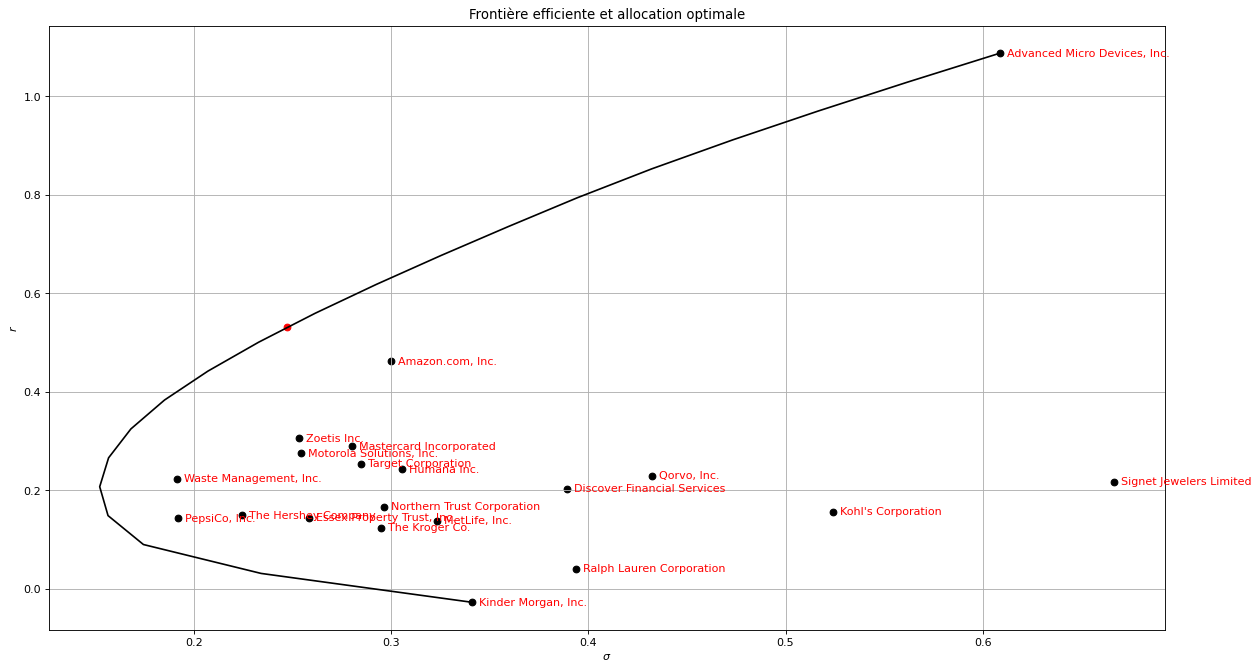

In [42]:
names, prices, caps = ticker_name, data_close, temporary_market_cap(tickers)
n = len(names) #chargement des données

# on calcule les rendements attendus et les covariances de nos actifs
names, W, R, C = calcul_meanvar(names, prices, caps)
rf = .025 #rendement actif sans risque

def print_assets(names, W, R, C):
        df = pd.DataFrame( columns = ["Nom", "Poids", "Rendements", "Std"])
        #print("%-10s %6s %6s %6s %s" % ("Nom", "Poids", "Rendements", "Std", "   Correlations"))
        for i in range(len(names)):
                df = df.append( {"Nom":names[i], 'Poids': round(100*W[i],3), 'Rendements': round(100*R[i],3) ,'Std': round(100*C[i,i]**.5,3)}, ignore_index = True
                            )
                #print("%-10s %5.1f%% %5.1f%% %5.1f%%    " % (names[i], 100*W[i], 100*R[i], 100*C[i,i]**.5), end='')
                #for j in range(i+1):
                #        corr = C[i,j] / (sqrt(C[i,i]) * (sqrt(C[j,j]))) # calcul des correlation à partir de la covariance
                #        print("%.3f " % corr, end='')
        df.index = df.Nom
        df = df.drop('Nom', axis = 1)
        print(df.to_markdown())

print("Allocation en utilisant les capitalisations (approche historique)")
print_assets(names, W, R, C)

# on calcule le rendement historique de notre portefeuille et sa variance
mean, var = mean_ptf_var(W, R, C)

# optimisation de notre portfeuille au sens de markowitz (maximise le ratio de sharpe) basé sur les prix historiques
print("\n")
ptf_optim("Optimisation au sens de Markowitz (approche du modèle)", names, R, C, rf, color='black')
show()

# Analyse sectorielle des actifs du portefeuille

L'idée de cette troisième partie c'est d’arriver à trouver et de construire des index qui ne sont pas disponible gratuitement. On a choisi de reproduire les poids des industries dans le S&P500 à partir de la taxonomie des GICS (crée par Standard & Poor’s).

- Dans un premier temps on réutilise le site réutilise Investing.com pour prendre les tickers qui composent notre portefeuille et grâce à une library de Yahoo finance, on recupere les prix de clôture ainsi que chaque Capitalisation Boursière de ces entreprises.
- Dans un deuxième temps on arrive à calculer les poids de chaque entreprise grâce à une division du MarketCap de chaque entreprise sur le MarketCap total de chaque entreprise.
- Enfin, à récuprère le secteur de chaque entreprise ainsi que les sous-secteurs lorsque cela est possible via eresearch.fidelity.com pour les secteurs et Wikipédia pour les sous-secteurs.

In [43]:
def geteGics(tickers):

    industryGics = []

    for tick in tickers:
        # rotation de ticker par page web
        url = 'https://eresearch.fidelity.com/eresearch/evaluate/snapshot.jhtml?symbols='+tick
        page = requests.get(url, verify=False)
        # Trouver a acceder a l'endroit precis dans la page. 
        soup = BeautifulSoup(page.content, 'html.parser')
        table = soup.find('div',{'id': 'companyProfile'})
        table = table.find_all('div',{'class': 'sub-heading'})[1]
        table = table.text.replace('\n','').replace('Industry (GICS®)','')
    

        industryGics.append(table.replace('.','/'))

    return industryGics

In [44]:
Industry_names=geteGics(tickers)
Industry_names

['Specialty Retail',
 'Beverages',
 'Oil, Gas & Consumable Fuels',
 'Multiline Retail',
 'Insurance',
 'Textiles, Apparel & Luxury Goods',
 'Internet & Direct Marketing Retail',
 'Consumer Finance',
 'IT Services',
 'Pharmaceuticals',
 'Capital Markets',
 'Commercial Services & Supplies',
 'Communications Equipment',
 'Food & Staples Retailing',
 'Health Care Providers & Services',
 'Food Products',
 'Equity Real Estate Investment Trusts (REITs)',
 'Semiconductors & Semiconductor Equipment',
 'Semiconductors & Semiconductor Equipment',
 'Multiline Retail']

In [45]:
weights = temporary_market_cap(tickers)
weights = array(weights) / sum(weights)

In [46]:
# Creation d'un DataFrame
d = {'Ticker': tickers,'Weight': weights, 'Industry':Industry_names}
df = pd.DataFrame(d)
# Les deux sites utilisent des formats de texte differents, surtout pour le and et & mais aussi majuscule et miniscule
# Donc on format tout de la meme maniere
df['Industry']=df['Industry'].str.replace('and', '&').str.title()
df.reset_index(drop=True, inplace = True)
df.head(10)

Ticker    Weight                            Industry
0    SIG  0.001572                    Specialty Retail
1    PEP  0.077267                           Beverages
2    KMI  0.012152         Oil, Gas & Consumable Fuels
3    TGT  0.035254                    Multiline Retail
4    MET  0.017478                           Insurance
5     RL  0.002891    Textiles, Apparel & Luxury Goods
6   AMZN  0.535966  Internet & Direct Marketing Retail
7    DFS  0.011367                    Consumer Finance
8     MA  0.118113                         It Services
9    ZTS  0.032941                     Pharmaceuticals

In [47]:
def extract_content(url):
    
    # Fonction d'extraction des données de la page
    page = requests.get(url, verify=False)
    soup = BeautifulSoup(page.content,'html.parser')
    content = soup.prettify()
    return content

In [48]:
def parse_content():
    
    # Fonction qui recupere toute la table Wikipédia avec le nom du sous secteur et son code.
    content = extract_content('https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard')
    content = content.split('wikitable')[1]
    content = content.replace('/','')
    content = content.replace('\n','')
    content = content.replace('amp;','')
    content = content.replace('<td>','<td>/')
    lines = content.split('<tr>')
    

    tout = ''
    for i in lines[2:] : 
        text = i.split('<td>')
        for j in text :
            j = re.sub('<[^>]+>', '', j)
            tout += j
    tout=re.sub(' +',' ',tout)
    tout = tout.replace('/ /','/')
    tout = tout.split('Revision')[0]
    tout = tout.strip()
    tout = tout.split('/')

    liste_code = []
    liste_int = []

    for i in range(0, len(tout)-1,2):
        liste_code.append(tout[i].strip())
        liste_int.append(tout[i+1].strip())

    manpage = pd.DataFrame()
    manpage['code'] = liste_code
    manpage['intitule'] = liste_int
    manpage['intitule'] = manpage['intitule'].str.replace('and','&').str.title()

    return manpage

mainpage = parse_content()

In [49]:
mainpage.head()

code                        intitule
0        10                          Energy
1      1010                          Energy
2    101010     Energy Equipment & Services
3  10101010              Oil & Gas Drilling
4  10101020  Oil & Gas Equipment & Services

In [50]:
def get_ind(sub_ind):
    
    # Fonction qui arrive a detecter pour chaque ticker toutes les types d'industrie et/ou sous industrie qui fait partie

    possible = mainpage[mainpage['intitule'] == sub_ind]['code'].tolist()
    ind = ''
    ind_gr = ''
    sector = ''
    
    if len(possible)>0:

        code = possible[len(possible)==8]
        ind = mainpage[mainpage['code'] == code[:6]]['intitule'].tolist()[0]
        ind_gr = mainpage[mainpage['code'] == code[:4]]['intitule'].tolist()[0]
        sector = mainpage[mainpage['code'] == code[:2]]['intitule'].tolist()[0]

    return (ind,ind_gr,sector)

In [51]:
# Creation des nouvelles colonnes dans le dataframe initial
df['Industry'] = df['Industry'].map(lambda x: get_ind(x)[0])
df['Industry_Group'] = df['Industry'].map(lambda x: get_ind(x)[1])
df['Sector'] = df['Industry'].map(lambda x: get_ind(x)[2])

In [52]:
df = df[['Ticker','Weight','Industry_Group']]
df['Weight'] = df['Weight'].astype(str).astype('float64')
df.head()

Ticker    Weight            Industry_Group
0    SIG  0.001572                 Retailing
1    PEP  0.077267  Food, Beverage & Tobacco
2    KMI  0.012152                    Energy
3    TGT  0.035254                 Retailing
4    MET  0.017478                 Insurance

In [53]:
byindus = df.groupby(['Industry_Group']).sum()
byindus

Weight
Industry_Group                                          
Commercial & Professional Services              0.021766
Consumer Durables & Apparel                     0.002891
Diversified Financials                          0.019675
Energy                                          0.012152
Food & Staples Retailing                        0.011065
Food, Beverage & Tobacco                        0.090315
Health Care Equipment & Services                0.018837
Insurance                                       0.017478
Pharmaceuticals, Biotechnology & Life Sciences  0.032941
Real Estate                                     0.007310
Retailing                                       0.574955
Semiconductors & Semiconductor Equipment        0.058432
Software & Services                             0.118113
Technology Hardware & Equipment                 0.014070

In [54]:
fig = px.pie(byindus, values='Weight', names=byindus.index, title='Percentage of weigths by Industry group')
fig.show()

In [55]:
##### on a trié les poids des actifs dans l'ordre décroissant et on a choisi ne que 10 premières
df_top_10=df.sort_values(by=['Weight'], ascending=False).iloc[:10,]
fig2 = px.pie(df_top_10, values='Weight', names='Ticker', title='Percentage of weigths by Enterprise')
fig2.show()

In [56]:
df_top_10

Ticker    Weight                                  Industry_Group
6    AMZN  0.535966                                       Retailing
8      MA  0.118113                             Software & Services
1     PEP  0.077267                        Food, Beverage & Tobacco
18    AMD  0.052860        Semiconductors & Semiconductor Equipment
3     TGT  0.035254                                       Retailing
9     ZTS  0.032941  Pharmaceuticals, Biotechnology & Life Sciences
11     WM  0.021766              Commercial & Professional Services
14    HUM  0.018837                Health Care Equipment & Services
4     MET  0.017478                                       Insurance
12    MSI  0.014070                 Technology Hardware & Equipment

In [57]:
verification = byindus['Weight'].sum()
if verification > 0.9999:
    print("C'est bon")
else:
    print("C'est pas bon")
    
# ca doit faire 1 (ou presque)

C'est bon
